<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 1 - Food Classification Model (Individual)</h2><h3>AY2022/23 Semester</h3></th>
    </tr>
</table>

In [2]:
# Import the Required Packages
from tensorflow import keras
print('keras: ', keras.__version__)
import os
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

keras:  2.8.0


In [ ]:
!nvidia-smi

## Step 1: Data Loading

In [3]:
#base_dir = 'E:\\Keene\\DL\\Assignment 1\\Images\\'

base_dir = 'C:\\Users\\Keene Ng\\Keene\\School\\Yr 2.1\\DL\\Assignment 1\\Images\\'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

img_size = 150

In [ ]:
"""
This script will fetch individually compressed folders for each food item defined in `assigned_number`.
"""

""" 1. REPLACE THIS WITH YOUR NUMBER """
assigned_number = 31

""" 2. REPLACE THESE IF REQUIRED AND YOU KNOW WHAT YOU'RE DOING """
server_base = 'https://primary.sfo3.cdn.digitaloceanspaces.com'
content_dir = '/content'

s = f'''
  if [ ! -d {content_dir} ] || [ ! -d {content_dir}/train ] || [ ! -d {content_dir}/test ] || [ ! -d {content_dir}/validation ]; \
    then
      echo "Making directories..." && mkdir -p {content_dir} {content_dir}/train {content_dir}/test {content_dir}/validation; \
  fi

  if [ ! -d {content_dir}/Food_list ]; \
    then
      wget {server_base}/assignment_one/food_list.zip -O {content_dir}/food_list.zip && \
      unzip -q {content_dir}/food_list.zip -d {content_dir}/ && \
      rm {content_dir}/food_list.zip; \
    else
      echo "Food_list directory already exists, skipping..."
  fi
'''

with open("s.sh", "w+") as o:
  o.write(s)

!bash s.sh
!rm s.sh

s = ''
c = []
with open(os.path.join(content_dir, 'Food_list', f'{assigned_number}.txt'), 'r') as i:
  lines = i.read().splitlines()

  for food in lines:
    with open(f'{food}.sh', 'w+') as o2:
      o2.write(f'''
        if [ ! -d {content_dir}/foods/{food} ]; \
          then
            echo "Fetching {food}" && \
            wget {server_base}/assignment_one/{food}.zip -O {content_dir}/{food}.zip && \
            unzip -q {content_dir}/{food}.zip -d {content_dir}/foods/; \
            mkdir -p {content_dir}/train/{food} {content_dir}/validation/{food} {content_dir}/test/{food} && \
            find {content_dir}/foods/{food} -maxdepth 1 -type f | tee \
            >(head -750 | xargs cp -t {content_dir}/train/{food}) \
            >(tail -250 | head -200 | xargs cp -t {content_dir}/validation/{food}) | \
            (tail -50 | xargs cp -t {content_dir}/test/{food}) && \
            rm {content_dir}/{food}.zip; \
          else
            echo "Food directory for {food} already exists, skipping..."; \
        fi
      ''')

    s += f'bash {food}.sh & '
    c.append(f'{food}.sh')

with open('s.sh', 'w+') as o:
  o.write(f'{s}wait && rm {" ".join(c)}')

!bash s.sh
!rm s.sh

train_dir = os.path.join(content_dir, 'train')
validation_dir = os.path.join(content_dir, 'validation')
test_dir = os.path.join(content_dir, 'test')

## Step 2:  Develop the Image Classification Models

### Model #1

In [ ]:
# Build the Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(1024, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

# use categorical cross entropy for multi-class classification
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=3e-4),
              metrics=['acc'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 74, 74, 32)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 128)       36992     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                            
                                                                 
 dropout_37 (Dropout)        (None, 36, 36, 128)      

In [ ]:
# Train the Model
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_size, img_size),
        batch_size=75,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=40,
        class_mode='categorical')

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=40,
      validation_data=validation_generator,
      validation_steps=50)

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/40
100/100 [==============================] - 117s 1s/step - loss: 2.4019 - acc: 0.1385 - val_loss: 2.2518 - val_acc: 0.1860
Epoch 2/40
100/100 [==============================] - 68s 675ms/step - loss: 2.1478 - acc: 0.2193 - val_loss: 2.0169 - val_acc: 0.3160
Epoch 3/40
100/100 [==============================] - 110s 1s/step - loss: 2.0155 - acc: 0.2797 - val_loss: 1.8428 - val_acc: 0.3645
Epoch 4/40
100/100 [==============================] - 118s 1s/step - loss: 1.9069 - acc: 0.3268 - val_loss: 1.8290 - val_acc: 0.4090
Epoch 5/40
100/100 [==============================] - 94s 942ms/step - loss: 1.7982 - acc: 0.3708 - val_loss: 1.7003 - val_acc: 0.4085
Epoch 6/40
100/100 [==============================] - 71s 711ms/step - loss: 1.7217 - acc: 0.4000 - val_loss: 1.6521 - val_acc: 0.4310
Epoch 7/40
100/100 [==============================] - 71s 706ms/step - loss: 1.6177 - acc: 0.4349 - val_loss: 

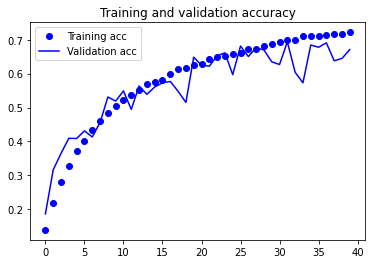

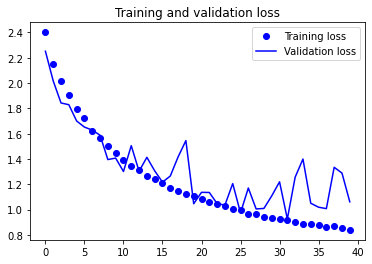

In [ ]:
# Plot the Training and Validation Accuracy & Loss Scores
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# Save the Model
model.save('food_model_1.h5')

### Model #2

In [4]:
# Build the Model
from tensorflow.keras.applications import Xception
img_size = 150

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(img_size, img_size, 3))

conv_base.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                          

In [5]:
model2 = models.Sequential()
model2.add(conv_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))



In [8]:
conv_base.trainable = False

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 33,971,506
Trainable params: 13,110,026
Non-trainable params: 20,861,480
_________________________________________________________________


In [10]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_size, img_size),
        batch_size=75,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=40,
        class_mode='categorical')

Found 7500 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [12]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block14_sepconv1':
        set_trainable = True # after block14_sepconv1, set_trainable becomes True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
             
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 33,971,506
Trainable params: 17,858,826
Non-trainable params: 16,112,680
_________________________________________________________________


In [13]:
#Train the Model
model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history = model2.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 77s 727ms/step - loss: 0.6509 - acc: 0.7945 - val_loss: 0.6475 - val_acc: 0.7920
Epoch 2/100
100/100 [==============================] - 72s 719ms/step - loss: 0.5820 - acc: 0.8067 - val_loss: 0.6335 - val_acc: 0.7860
Epoch 3/100
100/100 [==============================] - 72s 716ms/step - loss: 0.5430 - acc: 0.8211 - val_loss: 0.6094 - val_acc: 0.7925
Epoch 4/100
100/100 [==============================] - 72s 716ms/step - loss: 0.5297 - acc: 0.8267 - val_loss: 0.5898 - val_acc: 0.8040
Epoch 5/100
100/100 [==============================] - 72s 725ms/step - loss: 0.4915 - acc: 0.8401 - val_loss: 0.5745 - val_acc: 0.8070
Epoch 6/100
100/100 [==============================] - 72s 716ms/step - loss: 0.4926 - acc: 0.8385 - val_loss: 0.5811 - val_acc: 0.8035
Epoch 7/100
100/100 [==============================] - 71s 714ms/step - loss: 0.4781 - acc: 0.8456 - val_loss: 0.5721 - val_acc: 0.8155
Epoch 8/100
100/100 [===========================

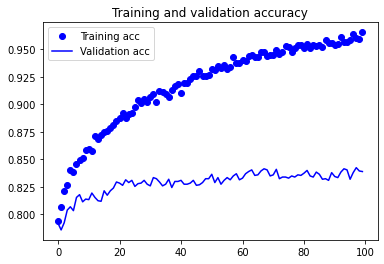

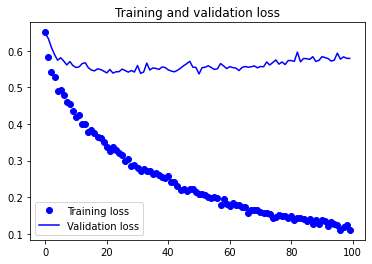

In [15]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
# Save the Model
model2.save('food_model_2.h5')

## Step 3 – Evaluate the Developed Models using Testing Images

In [ ]:
# Model #1
model = keras.models.load_model('food_model_1.h5')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=20,
        class_mode='categorical')

score = model.evaluate(test_generator, verbose=2)


Found 500 images belonging to 10 classes.
25/25 - 18s - loss: 0.9031 - acc: 0.7080 - 18s/epoch - 720ms/step


In [7]:
# Model #2
model2 = keras.models.load_model('food_model_2.h5')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_size, img_size),
        batch_size=20,
        class_mode='categorical')

score = model2.evaluate(test_generator, verbose=2)


Found 500 images belonging to 10 classes.
25/25 - 14s - loss: 0.5759 - acc: 0.8240 - 14s/epoch - 544ms/step


In [8]:
# Save the best model

model2.save('food_model_best.h5')

## Step 4  – Use the best model to make prediction

In [5]:
# Load the model
model = keras.models.load_model('food_model_best.h5')

In [6]:
# Load the food list (in alphabetical order)
label_file = os.path.join(base_dir, '31.txt')
with open(label_file, 'r') as f: # the .txt file which contains a list of food assigned to you
    x = f.readlines()
food_list =[]
for item in x:
    food_list.append(item.strip('\n'))
food_list = sorted(food_list) # food_list needs to be sorted alphabetically before feed into prediction() function
print(food_list)

['beet_salad', 'bibimbap', 'bread_pudding', 'clam_chowder', 'french_fries', 'onion_rings', 'pho', 'scallops', 'sushi', 'takoyaki']


In [7]:
# Define some related functions for image process and model prediction
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def image_process(img):
    image = load_img(img, target_size =(img_size, img_size))
    image_array = img_to_array(image)/255
    return image_array

import pandas as pd
def prediction(model, img_array, items_l):
    prob = model.predict(img_array.reshape(1,img_size,img_size,3))
    pro_df = pd.DataFrame(prob, columns = items_l)
    result = items_l[np.argmax(prob)]
    return pro_df, result

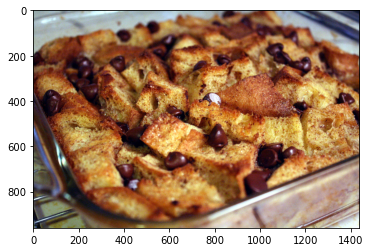

The prediction is:  bread_pudding 

    beet_salad  bibimbap  bread_pudding  clam_chowder  french_fries  \
0    0.000139  0.000136       0.987939      0.001173      0.001091   

   onion_rings       pho  scallops     sushi  takoyaki  
0     0.000888  0.000056  0.003191  0.000398  0.004989  


In [12]:
# Make prediction for the image you downloaded from internet
import matplotlib.pyplot as plt
label_file = os.path.join(base_dir, 'Bread_Pudding_Pred.jpg')
img = label_file # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

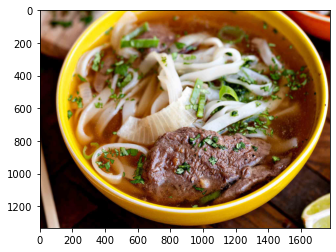

The prediction is:  pho 

    beet_salad  bibimbap  bread_pudding  clam_chowder  french_fries  \
0    0.003215  0.214332       0.000226      0.000004  5.519667e-07   

    onion_rings       pho  scallops     sushi  takoyaki  
0  5.655635e-07  0.782033   0.00009  0.000087  0.000012  


In [13]:
label_file = os.path.join(base_dir, 'Pho_Pred.jpg')
img = label_file # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

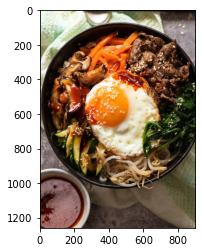

The prediction is:  bibimbap 

      beet_salad  bibimbap  bread_pudding  clam_chowder  french_fries  \
0  4.855987e-07  0.999993       0.000006  1.171449e-08  1.507101e-09   

    onion_rings           pho      scallops         sushi      takoyaki  
0  9.138283e-09  9.717235e-08  3.997055e-07  3.196901e-08  4.547354e-08  


In [16]:
label_file = os.path.join(base_dir, 'Bibimbap_Pred.jpg')
img = label_file # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)

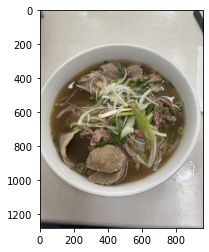

The prediction is:  pho 

    beet_salad  bibimbap  bread_pudding  clam_chowder  french_fries  \
0    0.001909  0.000763       0.000827      0.000834      0.000046   

    onion_rings       pho  scallops     sushi  takoyaki  
0  8.534352e-07  0.926763  0.068487  0.000002  0.000367  


In [8]:
label_file = os.path.join(base_dir, 'RealPho.jpg')
img = label_file # the picture you downloaded from internet, which contains a type of food in your food list
plt.imshow(plt.imread(img))
plt.show()

img_array = image_process(img)
prob_df, result = prediction(model, img_array, food_list)
print('The prediction is: ', result, '\n\n', prob_df)